In [13]:
!pip install numpy matplotlib graphviz

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

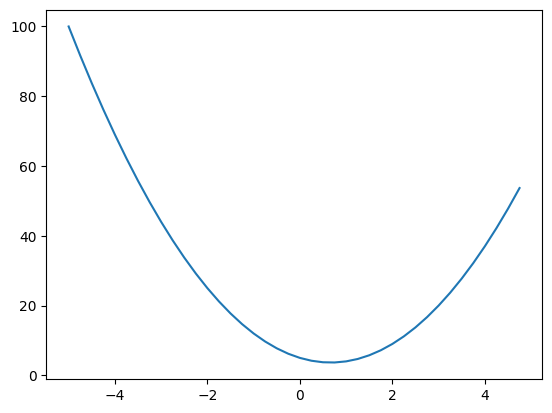

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [152]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

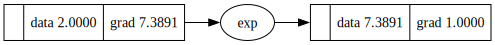

In [153]:
a = Value(2)
b = Value(3)
b = a.exp()
b.backward()
b.grad
draw_dot(b)

In [154]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Install Graphviz

`brew install graphviz`

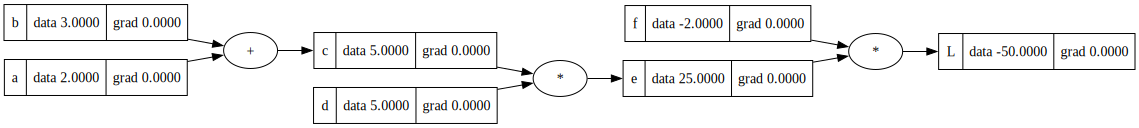

In [155]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a+b; c.label='c'
d = Value(5.0, label='d')
e = c*d; e.label='e'
f = Value(-2.0, label='f')
L = f*e; L.label='L'

draw_dot(L)

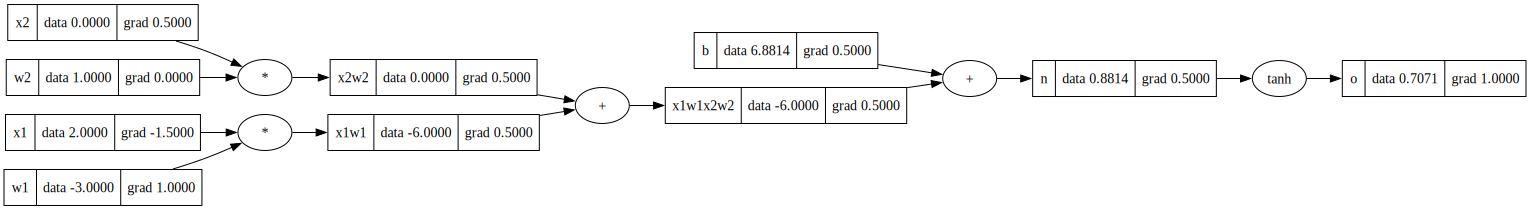

In [156]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#Linear functions
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label='x2w2'

#Final Product
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'

#output
n = x1w1x2w2 + b; n.label='n'

#Activation Function
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

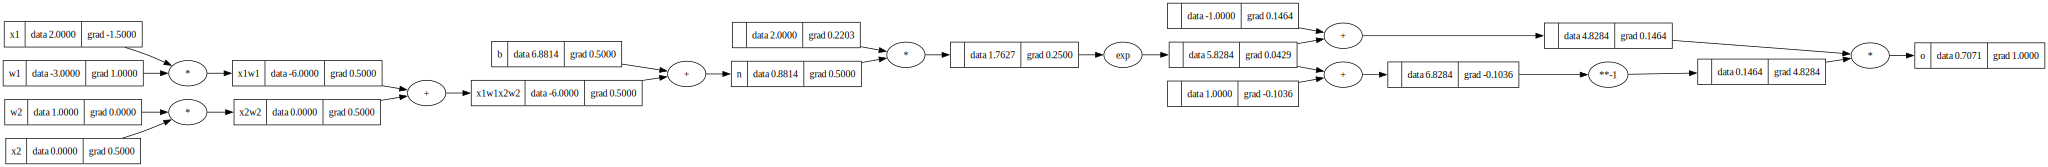

In [158]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#Linear functions
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label='x2w2'

#Final Product
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'

#output
n = x1w1x2w2 + b; n.label='n'

# ---
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ---

o.label = 'o'

o.backward()

draw_dot(o)

In [159]:
#Topological Sort

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=0.7071067811865477)]

In [160]:
o.grad = 1.0

for node in reversed(topo):
    node._backward()

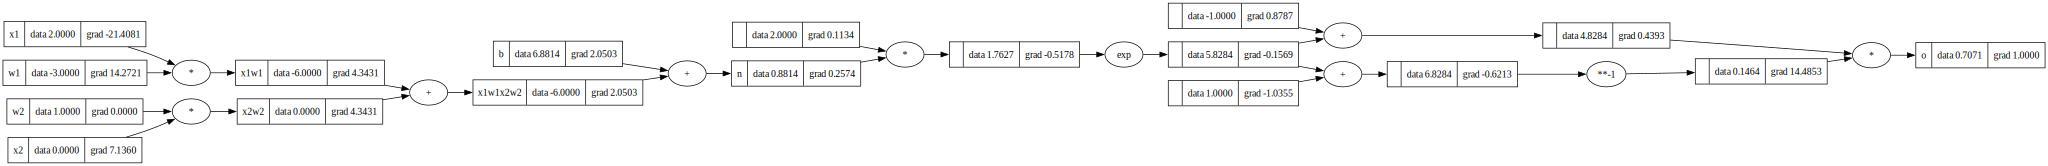

In [161]:
o.backward()

draw_dot(o)

In [162]:
import random

In [220]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

In [219]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [218]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
            for layer in self.layers:
                x = layer(x)
            return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [210]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)


[Value(data=-0.9769774916142961),
 Value(data=0.15460227294875925),
 Value(data=0.8320466697876917)]

In [310]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.1257014542578611)

In [223]:
len(n.parameters())

41

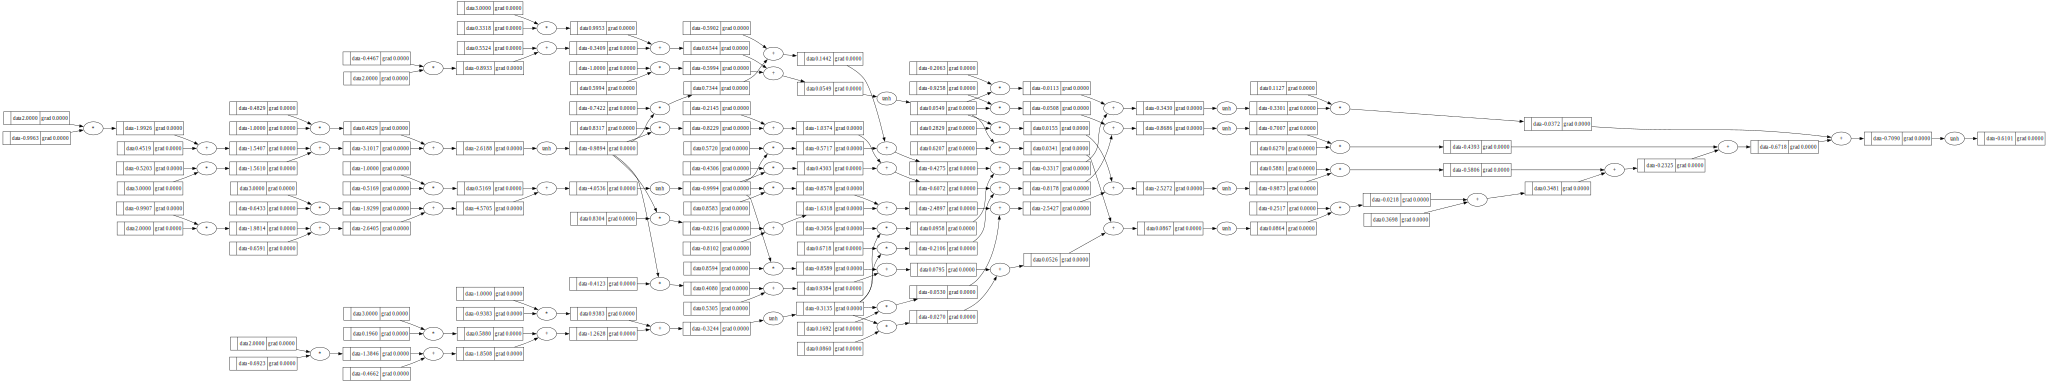

In [224]:
draw_dot(n(x))

In [265]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [628]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -0.5 * p.grad
  
    print(k, loss.data)

0 1.7402729954969652e-05
1 1.739738036676304e-05
2 1.7392034000030028e-05
3 1.7386690851879368e-05
4 1.7381350919424607e-05
5 1.737601419977977e-05
6 1.7370680690065675e-05
7 1.736535038740699e-05
8 1.7360023288927163e-05
9 1.7354699391755912e-05
10 1.734937869302793e-05
11 1.7344061189878558e-05
12 1.7338746879447902e-05
13 1.7333435758880705e-05
14 1.732812782532218e-05
15 1.7322823075922154e-05
16 1.7317521507835167e-05
17 1.731222311821672e-05
18 1.730692790422895e-05
19 1.730163586303404e-05


In [629]:

ypred = [n(x) for x in xs]
ypred

[Value(data=0.998275941747374),
 Value(data=-0.998768772138378),
 Value(data=-0.9971463159145497),
 Value(data=0.9978402464893963)]

In [630]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.7296346991799374e-05)

In [496]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [497]:
loss.backward()

In [498]:
n.layers[0].neurons[0].w[0].grad

-1.4194416324373444e-05

In [278]:
n.layers[0].neurons[0].w[0].data

0.5082242201700901

In [501]:
n.layers[0].neurons[0].w[0].data

-0.6325326592129566

In [499]:
n.parameters()

[Value(data=-0.6325326592129566),
 Value(data=-0.39049350631829244),
 Value(data=-0.5560425439926537),
 Value(data=0.04909903790527312),
 Value(data=0.9476902695499088),
 Value(data=-0.5302258286546033),
 Value(data=-0.744894569798713),
 Value(data=-0.03812404085727636),
 Value(data=-0.15841523686150108),
 Value(data=0.4462245868816612),
 Value(data=-1.3623201231083852),
 Value(data=-0.2714028832837568),
 Value(data=0.013049317532939161),
 Value(data=1.2883304530229744),
 Value(data=0.5920301912303839),
 Value(data=-0.0823972276730082),
 Value(data=-0.020567320182128757),
 Value(data=-0.2972496626737009),
 Value(data=-1.2683502226415357),
 Value(data=-0.20735355161005792),
 Value(data=0.16423443112596073),
 Value(data=0.1861393933530886),
 Value(data=-0.7046307260141389),
 Value(data=0.8033112611372887),
 Value(data=0.7268311329092525),
 Value(data=0.022542166315109108),
 Value(data=0.635821284718113),
 Value(data=0.8956774492006423),
 Value(data=1.2333129253328352),
 Value(data=0.2548